###### Content provided under a Creative Commons Attribution license CC-BY 4.0; code under BSD 3-Clause license. (c)2015 L.A. Barba, Olivier Mesnard, Pi-Yueh Chuang, Natalia Clementi.

# Vortex-source panel method

In [Lesson 9](09_Lesson09_flowOverCylinder.ipynb) of _AeroPython_, you learned to use a _source panel method_ to represent a circular cylinder, and in [Lesson 10](10_Lesson10_sourcePanelMethod.ipynb) we used it for a symmetric airfoil at zero angle of attack. But what if we want the airfoil to generate some lift? If we place the airfoil at a non-zero angle of attack, we _should_ get lift, but will a source-panel representation be able to give you lift? Remember the [_Kutta-Joukowski theorem_](http://en.wikipedia.org/wiki/Kutta%E2%80%93Joukowski_theorem)?


Historically, the first panel method ever developed was a source-sheet method. At the time, Douglas Aircraft Company was concerned with calculating the flow around bodies of revolution, and it was only later that the method was extended to lifting surfaces. (See the reference below for a nice historical account.)

A *source-panel method* leads to a solution with no circulation, therefore no lift. The objective of this lesson is to start with the source panel method we implemented in the previous lesson and add some *circulation* so that we may have a lift force. We introduce an important concept: the **Kutta-condition** that allows us to determine what the right amount of circulation should be.

##### Reference

* Smith, A.M.O., The Panel Method: Its Original Development. In _Applied Computational Aerodynamics_, Vol. 125, edited by P.A. Henne, published by AIAA (1990). [Read it on Google Books.](http://books.google.com/books?id=5Ov2tHj0wxoC&lpg=PA3&ots=SnUiqcdEnb&dq=The%20Panel%20Method%3A%20Its%20Original%20Development&pg=PA3#v=onepage&q&f=false)

## A lifting-body panel method

If we were to simply increase the angle of attack in the freestream and calculate the flow with a source sheet only, the rear stagnation point will not be located at the trailing edge. Instead, the flow will bend around the trailing edge and the stagnation point will be somewhere on the top surface of the airfoil. This is not a physically possible solution.

For example, using the source-sheet panel method of [Lesson 10](10_Lesson10_sourcePanelMethod.ipynb) with an angle of attack $\alpha=4^\circ$ (using 40 panels), and plotting the streamlines in an area close to the trailing edge, we get the following plot:

<center><img src="./resources/StreamlinesTrailingEdge.png" width="600"></center>

As you can see, the streamlines behave strangely at the trailing edge. We know experimentally that the flow leaves the trailing edge of an airfoil smoothly, so this must be wrong. What's wrong?  We can't exclusively use sources to calculate the potential flow of an airfoil at non-zero angle of attack--we need circulation. But how do we obtain circulation?

### The Kutta condition

The *Kutta-condition* states that the pressure below and above the airfoil trailing edge must be equal so that the flow does not bend around it and instead leaves the airfoil tangentially. The rear stagnation point must be exactly at the trailing edge.

It's natural to be a little perplexed by this. How can we justify this seemingly arbitrary condition? Remember that potential-flow theory completely ignores fluid viscosity, so if we are leaving out this physical effect, we shouldn't be surprised that the theory needs some adjustment for those situations when viscosity does play a role. A real viscous fluid is not able to turn around a sharp corner like an airfoil trailing edge without separating there. The Kutta condition allows us to correct potential-flow theory so that it gives a solution closer to reality.

Remember [Lesson 6](06_Lesson06_vortexLift.ipynb), where we studied lift on a cylinder by combining a doublet and a freestream, plus a vortex. That's when we learned that **lift always requires circulation**. If you experimented with the circulation of the point vortex (which you *did*, right?), you found that the stagnation points moved along the cylinder.

Like for the circular cylinder, the amount of circulation we add to an airfoil will move the stagnation points along the surface. And if we add just the right amount, the rear stagnation point can be made to coincide with the trailing edge. This amount of circulation makes the flow a physically relevant solution. And this amount gives the correct lift!

To implement the Kutta-condition in our panel method we need to add one more equation to the system, giving the circulation that moves the stagnation point to the trailing edge. By placing a vortex-sheet with the same constant strength at every panel, we can add the circulation to the flow with just one more unknown.

How do we enforce this in our code? We can re-use most of the code from [Lesson 10](10_Lesson10_sourcePanelMethod.ipynb), and enforce the Kutta-condition while adding circulation to the flow. Previously, we discretized the geometry into `N` panels, with a constant source strength on each one (varying from panel to panel), and applied a Neumann boundary condition of flow tangency at the `N` panel centers. This led to a linear system of `N` equations and `N` unknowns that we solved with the SciPy function `linalg.solve`. In the lifting-body case, we will instead have `N+1` equations and `N+1` unknowns. Read on to find out how!


### Discretization into panels

Let's get the preliminaries out of the way. We need to import our favorite libraries, and the function `integrate` from SciPy, as in Lesson 10.

In [2]:
# import libraries and modules needed
import os
import numpy
from scipy import integrate, linalg
from matplotlib import pyplot

We start by importing the NACA0012 geometry from a data file, and we plot the airfoil:

In [12]:
# load geometry from data file
naca_filepath = os.path.join('naca0012.dat')
with open(naca_filepath, 'r') as infile:
    x, y = numpy.loadtxt(infile, dtype=float, unpack=True)

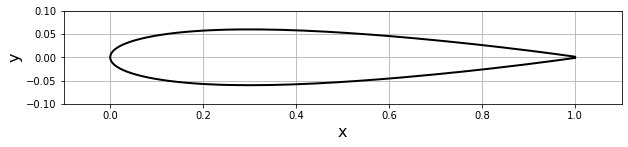

In [13]:
# plot geometry
width = 10
pyplot.figure(figsize=(width, width))
pyplot.grid()
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.plot(x, y, color='k', linestyle='-', linewidth=2)
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(-0.1, 1.1)
pyplot.ylim(-0.1, 0.1);

The contour defining the airfoil will be partitioned into `N` panels, using the same method as in [Lesson 10](10_Lesson10_sourcePanelMethod.ipynb).

We define a class `Panel`  that will store all information about one panel: start and end points, center point, length, orientation, source strength, tangential velocity and pressure coefficient. We don't save the vortex-sheet strength because all panels will have the same value.

In [14]:
class Panel:
    """
    Contains information related to a panel.
    """
    def __init__(self, xa, ya, xb, yb):
        """
        Initializes the panel.
        
        Sets the end-points and calculates the center-point, length,
        and angle (with the x-axis) of the panel.
        Defines if the panel is located on the upper or lower surface of the geometry.
        Initializes the source-strength, tangential velocity, and pressure coefficient
        of the panel to zero.
        
        Parameters
        ---------_
        xa: float
            x-coordinate of the first end-point.
        ya: float
            y-coordinate of the first end-point.
        xb: float
            x-coordinate of the second end-point.
        yb: float
            y-coordinate of the second end-point.
        """
        self.xa, self.ya = xa, ya  # panel starting-point
        self.xb, self.yb = xb, yb  # panel ending-point
        
        self.xc, self.yc = (xa + xb) / 2, (ya + yb) / 2  # panel center
        self.length = numpy.sqrt((xb - xa)**2 + (yb - ya)**2)  # panel length
        
        # orientation of panel (angle between x-axis and panel's normal)
        if xb - xa <= 0.0:
            self.beta = numpy.arccos((yb - ya) / self.length)
        elif xb - xa > 0.0:
            self.beta = numpy.pi + numpy.arccos(-(yb - ya) / self.length)
        
        # panel location
        if self.beta <= numpy.pi:
            self.loc = 'upper'  # upper surface
        else:
            self.loc = 'lower'  # lower surface
        
        self.sigma = 0.0  # source strength
        self.vt = 0.0  # tangential velocity
        self.cp = 0.0  # pressure coefficient

Like before, we call the function `define_panels` to discretize the airfoil geometry in `N` panels. The function will return a NumPy array of `N` objects of the type `Panel`.

In [15]:
def define_panels(x, y, N=40):
    """
    Discretizes the geometry into panels using 'cosine' method.
    
    Parameters
    ----------
    x: 1D array of floats
        x-coordinate of the points defining the geometry.
    y: 1D array of floats
        y-coordinate of the points defining the geometry.
    N: integer, optional
        Number of panels;
        default: 40.
    
    Returns
    -------
    panels: 1D Numpy array of Panel objects.
        The list of panels.
    """
    
    R = (x.max() - x.min()) / 2.0  # circle radius
    x_center = (x.max() + x.min()) / 2.0  # x-coordinate of circle center
    
    theta = numpy.linspace(0.0, 2.0 * numpy.pi, N + 1)  # array of angles
    x_circle = x_center + R * numpy.cos(theta)  # x-coordinates of circle
    
    x_ends = numpy.copy(x_circle)  # x-coordinate of panels end-points
    y_ends = numpy.empty_like(x_ends)  # y-coordinate of panels end-points
    
    # extend coordinates to consider closed surface
    x, y = numpy.append(x, x[0]), numpy.append(y, y[0])
    
    # compute y-coordinate of end-points by projection
    I = 0
    for i in range(N):
        while I < len(x) - 1:
            if (x[I] <= x_ends[i] <= x[I + 1]) or (x[I + 1] <= x_ends[i] <= x[I]):
                break
            else:
                I += 1
        a = (y[I + 1] - y[I]) / (x[I + 1] - x[I])
        b = y[I + 1] - a * x[I + 1]
        y_ends[i] = a * x_ends[i] + b
    y_ends[N] = y_ends[0]
    
    # create panels
    panels = numpy.empty(N, dtype=object)
    for i in range(N):
        panels[i] = Panel(x_ends[i], y_ends[i], x_ends[i + 1], y_ends[i + 1])
    
    return panels

Now we can use our new function to define the geometry for the airfoil panels, and then plot the panel nodes on the geometry.

In [16]:
# discretize geoemetry into panels
panels = define_panels(x, y, N=40)

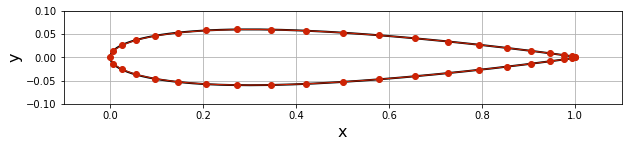

In [17]:
# plot discretized geometry
width = 10
pyplot.figure(figsize=(width, width))
pyplot.grid()
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.plot(x, y, color='k', linestyle='-', linewidth=2)
pyplot.plot(numpy.append([panel.xa for panel in panels], panels[0].xa),
            numpy.append([panel.ya for panel in panels], panels[0].ya),
            linestyle='-', linewidth=1, marker='o', markersize=6, color='#CD2305')
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(-0.1, 1.1)
pyplot.ylim(-0.1, 0.1);

### Free stream conditions

The airfoil is immersed in a free-stream $(U_\infty$,$\alpha)$ where $U_\infty$ and $\alpha$ are the velocity magnitude and angle of attack, respectively. Like before, we create a class for the free stream, even though we will only have one object that uses this class. It makes it easier to pass the free stream to other functions later on.

In [18]:
class Freestream:
    """
    Freestream conditions.
    """
    def __init__(self, u_inf=1.0, alpha=0.0):
        """
        Sets the freestream speed and angle (in degrees).
        
        Parameters
        ----------
        u_inf: float, optional
            Freestream speed;
            default: 1.0.
        alpha: float, optional
            Angle of attack in degrees;
            default 0.0.
        """
        self.u_inf = u_inf
        self.alpha = numpy.radians(alpha)  # degrees to radians

In [19]:
# define freestream conditions
freestream = Freestream(u_inf=1.0, alpha=4.0)

### Flow tangency boundary condition

A constant vortex strength $\gamma$ will be added to each panel (all panels have the same, constant vortex-sheet strength). Thus, using the principle of superposition, the velocity potential becomes:

$$
\begin{align*}
\phi\left(x_{c_i},y_{c_i}\right) &= V_\infty x_{c_i} \cos \alpha + V_\infty y_{c_i} \sin \alpha \\
&+ \sum_{j=1}^N \frac{\sigma_j}{2\pi} \int_j \ln \left(\sqrt{(x_{c_i}-x_j(s_j))^2+(y_{c_i}-y_j(s_j))^2} \right) {\rm d}s_j \\
&- \sum_{j=1}^N \frac{\gamma}{2\pi} \int_j \tan^{-1} \left(\frac{y_{c_i}-y_j(s_j)}{x_{c_i}-x_j(s_j)}\right) {\rm d}s_j
\end{align*}
$$

The flow tangency boundary condition is applied at every panel center:

$$0 = \vec{V}\cdot\vec{n}_i = \frac{\partial}{\partial n_i} \left\{ \phi\left(x_{c_i},y_{c_i}\right) \right\}$$

i.e.

$$
\begin{align*}
0 &= V_\infty \cos \left(\alpha-\beta_i\right) + \frac{\sigma_i}{2} \\
&+ \sum_{j=1,j\neq i}^N \frac{\sigma_j}{2\pi} \int_j \frac{\partial}{\partial n_i} \ln \left(\sqrt{(x_{c_i}-x_j(s_j))^2+(y_{c_i}-y_j(s_j))^2} \right) {\rm d}s_j \\
&- \sum_{j=1,j\neq i}^N \frac{\gamma}{2\pi} \int_j \frac{\partial}{\partial n_i} \tan^{-1} \left(\frac{y_{c_i}-y_j(s_j)}{x_{c_i}-x_j(s_j)}\right) {\rm d}s_j
\end{align*}
$$

We already worked the first integral in the previous lesson:

$$\frac{\partial}{\partial n_i} \ln \left(\sqrt{(x_{c_i}-x_j(s_j))^2+(y_{c_i}-y_j(s_j))^2} \right) = \frac{\left(x_{c_i}-x_j\right)\frac{\partial x_{c_i}}{\partial n_i} + \left(y_{c_i}-y_j\right)\frac{\partial y_{c_i}}{\partial n_i}}{\left(x_{c_i}-x_j\right)^2 + \left(y_{c_i}-y_j\right)^2}$$

where $\frac{\partial x_{c_i}}{\partial n_i} = \cos \beta_i$ and $\frac{\partial y_{c_i}}{\partial n_i} = \sin \beta_i$, and

$$x_j(s_j) = x_{b_j} - s_j \sin \beta_j$$

$$y_j(s_j) = y_{b_j} + s_j \cos \beta_j$$

We now need to derive the last integral of the boundary equation:

$$\frac{\partial}{\partial n_i} \tan^{-1} \left(\frac{y_{c_i}-y_j(s_j)}{x_{c_i}-x_j(s_j)}\right)= \frac{\left(x_{c_i}-x_j\right)\frac{\partial y_{c_i}}{\partial n_i} - \left(y_{c_i}-y_j\right)\frac{\partial x_{c_i}}{\partial n_i}}{\left(x_{c_i}-x_j\right)^2 + \left(y_{c_i}-y_j\right)^2}$$

where $\frac{\partial x_{c_i}}{\partial n_i} = \cos \beta_i$ and $\frac{\partial y_{c_i}}{\partial n_i} = \sin \beta_i$.

### Enforcing the Kutta condition

To enforce the *Kutta-condition*, we state that the pressure coefficient on the first panel must be equal to that on the last panel:

$$C_{p_1} = C_{p_{N}}$$

Using the definition of the pressure coefficient $C_p = 1-\left(\frac{V}{U_\infty}\right)^2$, the Kutta-condition implies that the magnitude of the velocity at the first panel center must equal the magnitude of the last panel center:

$$V_1^2 = V_N^2$$

Since the flow tangency condition requires that $V_{n_1} = V_{n_N} = 0$, we end up with the following *Kutta-condition*:

$$V_{t_1} = - V_{t_N}$$

(the minus sign comes from the reference axis we chose for the normal and tangential vectors).


Let's derive the tangential velocity for every panel, since it will be useful to compute the pressure coefficient.

$$V_{t_i} = \frac{\partial}{\partial t_i} \left(\phi\left(x_{c_i},y_{c_i}\right)\right)$$

i.e.,

$$
\begin{align*}
V_{t_i} &= V_\infty \sin \left(\alpha-\beta_i\right) \\
&+ \sum_{j=1,j\neq i}^N \frac{\sigma_j}{2\pi} \int_j \frac{\partial}{\partial t_i} \ln \left(\sqrt{(x_{c_i}-x_j(s_j))^2+(y_{c_i}-y_j(s_j))^2} \right) {\rm d}s_j \\
&- \sum_{j=1,j\neq i}^N \frac{\gamma}{2\pi} \int_j \frac{\partial}{\partial t_i} \tan^{-1} \left(\frac{y_{c_i}-y_j(s_j)}{x_{c_i}-x_j(s_j)}\right) {\rm d}s_j \\
&-\frac{\gamma}{2}
\end{align*}
$$


which gives

$$
\begin{align*}
V_{t_i} &= V_\infty \sin \left(\alpha-\beta_i\right) \\
&+ \sum_{j=1,j\neq i}^N \frac{\sigma_j}{2\pi} \int_j \frac{\left(x_{c_i}-x_j\right)\frac{\partial x_{c_i}}{\partial t_i} + \left(y_{c_i}-y_j\right)\frac{\partial y_{c_i}}{\partial t_i}}{\left(x_{c_i}-x_j\right)^2 + \left(y_{c_i}-y_j\right)^2} {\rm d}s_j \\
&- \sum_{j=1,j\neq i}^N \frac{\gamma}{2\pi} \int_j \frac{\left(x_{c_i}-x_j\right)\frac{\partial y_{c_i}}{\partial t_i} - \left(y_{c_i}-y_j\right)\frac{\partial x_{c_i}}{\partial t_i}}{\left(x_{c_i}-x_j\right)^2 + \left(y_{c_i}-y_j\right)^2} {\rm d}s_j \\
&-\frac{\gamma}{2}
\end{align*}
$$

where $\frac{\partial x_{c_i}}{\partial t_i} = -\sin \beta_i$ and $\frac{\partial y_{c_i}}{\partial t_i} = \cos \beta_i$.

### Building the linear system

Here, we build and solve the linear system of equations of the form

$$[A][\sigma,\gamma] = [b]$$

where the $N+1 \times N+1$ matrix $[A]$ contains three blocks: an $N \times N$ source matrix (the same one of Lesson 10), an $N \times 1$ vortex array to store the weight of the variable $\gamma$ at each panel, and a $1 \times N+1$ Kutta array that repesents our Kutta-condition.

We are going to re-use the function `integral` from [Lesson 10](10_Lesson10_sourcePanelMethod.ipynb) to compute the different integrals with the SciPy function `integrate.quad`:

In [20]:
def integral(x, y, panel, dxdk, dydk):
    """
    Evaluates the contribution from a panel at a given point.
    
    Parameters
    ----------
    x: float
        x-coordinate of the target point.
    y: float
        y-coordinate of the target point.
    panel: Panel object
        Panel whose contribution is evaluated.
    dxdk: float
        Value of the derivative of x in a certain direction.
    dydk: float
        Value of the derivative of y in a certain direction.
    
    Returns
    -------
    Contribution from the panel at a given point (x, y).
    """
    def integrand(s):
        return (((x - (panel.xa - numpy.sin(panel.beta) * s)) * dxdk +
                 (y - (panel.ya + numpy.cos(panel.beta) * s)) * dydk) /
                ((x - (panel.xa - numpy.sin(panel.beta) * s))**2 +
                 (y - (panel.ya + numpy.cos(panel.beta) * s))**2) )
    return integrate.quad(integrand, 0.0, panel.length)[0]

We first define the function `source_contribution_normal` to build the source matrix, i.e. the weight from each source on the normal velocity of each panel:

In [21]:
def source_contribution_normal(panels):
    """
    Builds the source contribution matrix for the normal velocity.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    
    Returns
    -------
    A: 2D Numpy array of floats
        Source contribution matrix.
    """
    A = numpy.empty((panels.size, panels.size), dtype=float)
    # source contribution on a panel from itself
    numpy.fill_diagonal(A, 0.5)
    # source contribution on a panel from others
    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i != j:
                A[i, j] = 0.5 / numpy.pi * integral(panel_i.xc, panel_i.yc, panel_j,
                                                    numpy.cos(panel_i.beta),
                                                    numpy.sin(panel_i.beta))
    return A

Then, we define `vortex_contribution_normal` to build the vortex matrix:

In [22]:
def vortex_contribution_normal(panels):
    """
    Builds the vortex contribution matrix for the normal velocity.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    
    Returns
    -------
    A: 2D Numpy array of floats
        Vortex contribution matrix.
    """
    A = numpy.empty((panels.size, panels.size), dtype=float)
    # vortex contribution on a panel from itself
    numpy.fill_diagonal(A, 0.0)
    # vortex contribution on a panel from others
    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i != j:
                A[i, j] = -0.5 / numpy.pi * integral(panel_i.xc, panel_i.yc, 
                                                     panel_j,
                                                     numpy.sin(panel_i.beta),
                                                     -numpy.cos(panel_i.beta))
    return A

Let's call both of these functions to create the source matrix `A_source` and the vortex matrix `B_vortex`:

In [23]:
A_source = source_contribution_normal(panels)
B_vortex = vortex_contribution_normal(panels)

We still have to include the Kutta condition in our system.

Following this lesson, there is an [exercise](11_Lesson11_Exercise.ipynb) for you to complete, which will help you to show that:

* the matrix resulting from the contribution of the vortices on the normal velocity, $B^n$, is **exactly** the matrix resulting from the contribution of the sources on the tangential velocity, $A^t$, i.e.

$$B^n_{ij}=A^t_{ij} \quad \forall (i, j) \in \{1, \cdots, N\}^2$$

* the matrix resulting from the contribution of the vortices on the tangential velocity, $B^t$, is the **opposite** of the matrix resulting from the contribution of the sources on the normal velocity, $A^n$, i.e.

$$B^t_{ij}=-A^n_{ij} \quad \forall (i, j) \in \{1, \cdots, N\}^2$$

where the superscripts $n$ and $t$ denote the normal and tangential velocity components, respectively.

Thus, the Kutta condition can be cast in the following form

$$
\begin{bmatrix}
(A^t_{11}+A^t_{N1}) \\
\vdots \\ 
(A^t_{1N}+A^t_{NN}) \\
\left( \sum_{j=1}^N (B^t_{1j}+B^t_{Nj}) \right)
\end{bmatrix}^T
\begin{bmatrix}
\sigma_1 \\
\vdots \\
\sigma_N \\
\gamma
\end{bmatrix} = -(b^t_1+b^t_N)
$$

Let's define a function `kutta_condition` that does the job:

In [24]:
def kutta_condition(A_source, B_vortex):
    """
    Builds the Kutta condition array.
    
    Parameters
    ----------
    A_source: 2D Numpy array of floats
        Source contribution matrix for the normal velocity.
    B_vortex: 2D Numpy array of floats
        Vortex contribution matrix for the normal velocity.
    
    Returns
    -------
    b: 1D Numpy array of floats
        The left-hand side of the Kutta-condition equation.
    """
    b = numpy.empty(A_source.shape[0] + 1, dtype=float)
    # matrix of source contribution on tangential velocity
    # is the same than
    # matrix of vortex contribution on normal velocity
    b[:-1] = B_vortex[0, :] + B_vortex[-1, :]
    # matrix of vortex contribution on tangential velocity
    # is the opposite of
    # matrix of source contribution on normal velocity
    b[-1] = - numpy.sum(A_source[0, :] + A_source[-1, :])
    return b

We now have all the ingredients we need.  The function `build_singularity_matrix` will gather together the source matrix, the vortex array, and the Kutta array to build the matrix needed to solve the linear system. 

In [25]:
def build_singularity_matrix(A_source, B_vortex):
    """
    Builds the left-hand side matrix of the system
    arising from source and vortex contributions.
    
    Parameters
    ----------
    A_source: 2D Numpy array of floats
        Source contribution matrix for the normal velocity.
    B_vortex: 2D Numpy array of floats
        Vortex contribution matrix for the normal velocity.
    
    Returns
    -------
    A:  2D Numpy array of floats
        Matrix of the linear system.
    """
    A = numpy.empty((A_source.shape[0] + 1, A_source.shape[1] + 1), dtype=float)
    # source contribution matrix
    A[:-1, :-1] = A_source
    # vortex contribution array
    A[:-1, -1] = numpy.sum(B_vortex, axis=1)
    # Kutta condition array
    A[-1, :] = kutta_condition(A_source, B_vortex)
    return A

On the right-hand side, we store everything that does not depend on the unknown strengths.

In [26]:
def build_freestream_rhs(panels, freestream):
    """
    Builds the right-hand side of the system 
    arising from the freestream contribution.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    freestream: Freestream object
        Freestream conditions.
    
    Returns
    -------
    b: 1D Numpy array of floats
        Freestream contribution on each panel and on the Kutta condition.
    """
    b = numpy.empty(panels.size + 1, dtype=float)
    # freestream contribution on each panel
    for i, panel in enumerate(panels):
        b[i] = -freestream.u_inf * numpy.cos(freestream.alpha - panel.beta)
    # freestream contribution on the Kutta condition
    b[-1] = -freestream.u_inf * (numpy.sin(freestream.alpha - panels[0].beta) +
                                 numpy.sin(freestream.alpha - panels[-1].beta) )
    return b

In [27]:
A = build_singularity_matrix(A_source, B_vortex)
b = build_freestream_rhs(panels, freestream)

As in the previous lesson, we solve the linear system using the Scipy function `linalg.solve`. Then we store the results in the attribute `sigma` of each `Panel` object. We also create a variable `gamma` to store the value of the constant vortex strength.

In [28]:
# solve for singularity strengths
strengths = numpy.linalg.solve(A, b)

# store source strength on each panel
for i , panel in enumerate(panels):
    panel.sigma = strengths[i]
    
# store circulation density
gamma = strengths[-1]
print(strengths)

[-0.67957726 -0.63063937 -0.77297952 -0.83469959 -0.86323253 -0.87647511
 -0.8811647  -0.88029074 -0.87451189 -0.86495699 -0.85067662 -0.83098347
 -0.80334248 -0.76940141 -0.72527677 -0.66600663 -0.57279145 -0.41733802
 -0.0678225   0.83701513  1.69453652  1.4890824   1.24427272  1.08302603
  0.96579536  0.88100517  0.81551841  0.76591181  0.72849794  0.70309942
  0.6847072   0.67056431  0.65774685  0.64488178  0.62887869  0.60667078
  0.57179189  0.5086543   0.37871895  0.01143137  0.12418163]


## Surface pressure coefficient

The pressure coefficient at the $i$-th panel center is:

$$C_{p_i} = 1 - \left(\frac{V_{t_i}}{U_\infty}\right)^2$$

So, we have to compute the tangential velocity at each panel center using the function `compute_tangential_velocity`:

In [19]:
def compute_tangential_velocity(panels, freestream, gamma, A_source, B_vortex):
    """
    Computes the tangential surface velocity.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    freestream: Freestream object
        Freestream conditions.
    gamma: float
        Circulation density.
    A_source: 2D Numpy array of floats
        Source contribution matrix for the normal velocity.
    B_vortex: 2D Numpy array of floats
        Vortex contribution matrix for the normal velocity.
    """
    A = numpy.empty((panels.size, panels.size + 1), dtype=float)
    # matrix of source contribution on tangential velocity
    # is the same than
    # matrix of vortex contribution on normal velocity
    A[:, :-1] = B_vortex
    # matrix of vortex contribution on tangential velocity
    # is the opposite of
    # matrix of source contribution on normal velocity
    A[:, -1] = -numpy.sum(A_source, axis=1)
    # freestream contribution
    b = freestream.u_inf * numpy.sin([freestream.alpha - panel.beta 
                                      for panel in panels])
    
    strengths = numpy.append([panel.sigma for panel in panels], gamma)
    
    tangential_velocities = numpy.dot(A, strengths) + b
    
    for i, panel in enumerate(panels):
        panel.vt = tangential_velocities[i]

In [20]:
# tangential velocity at each panel center.
compute_tangential_velocity(panels, freestream, gamma, A_source, B_vortex)

And we define a function `compute_pressure_coefficient` to compute the surface pressure coefficient:

In [21]:
def compute_pressure_coefficient(panels, freestream):
    """
    Computes the surface pressure coefficients.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    freestream: Freestream object
        Freestream conditions.
    """
    for panel in panels:
        panel.cp = 1.0 - (panel.vt / freestream.u_inf)**2

In [22]:
# surface pressure coefficient
compute_pressure_coefficient(panels, freestream)

Time to plot the result!

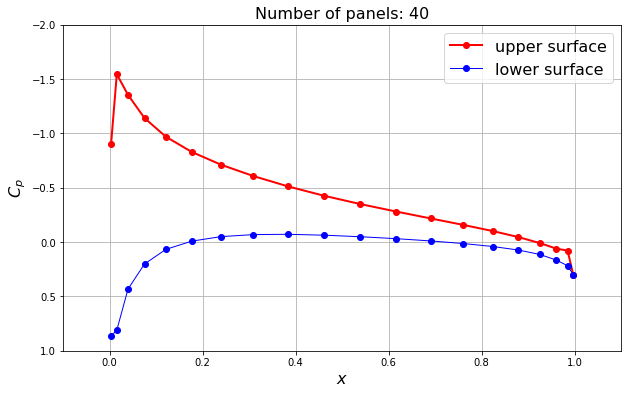

In [23]:
# plot surface pressure coefficient
pyplot.figure(figsize=(10, 6))
pyplot.grid()
pyplot.xlabel('$x$', fontsize=16)
pyplot.ylabel('$C_p$', fontsize=16)
pyplot.plot([panel.xc for panel in panels if panel.loc == 'upper'],
            [panel.cp for panel in panels if panel.loc == 'upper'],
            label='upper surface',
            color='r', linestyle='-', linewidth=2, marker='o', markersize=6)
pyplot.plot([panel.xc for panel in panels if panel.loc == 'lower'],
            [panel.cp for panel in panels if panel.loc == 'lower'],
            label= 'lower surface',
            color='b', linestyle='-', linewidth=1, marker='o', markersize=6)
pyplot.legend(loc='best', prop={'size':16})
pyplot.xlim(-0.1, 1.1)
pyplot.ylim(1.0, -2.0)
pyplot.title('Number of panels: {}'.format(panels.size), fontsize=16);

### Accuracy check

For a closed body, the sum of all the source strengths must be zero. If not, it means the body would be adding or absorbing mass from the flow! Therefore, we should have

$$\sum_{i=1}^{N} \sigma_i l_i = 0$$

where $l_i$ is the length of the $i^{\text{th}}$ panel.

With this, we can get a measure of the accuracy of the source panel method.

In [24]:
# calculate the accuracy
accuracy = sum([panel.sigma * panel.length for panel in panels])
print('sum of singularity strengths: {:0.6f}'.format(accuracy))

sum of singularity strengths: 0.004606


## Lift coefficient

The lift  is given by the Kutta-Joukowski theorem, $L = \rho \Gamma U_\infty$, 
where $\rho$ is the fluid density. The total circulation $\Gamma$ is given by:

$$\Gamma = \sum_{i=1}^N \gamma l_i$$

Finally, the lift coefficient is given by:

$$C_l = \frac{\sum_{i=1}^N \gamma l_i}{\frac{1}{2}U_\infty c}$$

with $c$ the chord-length of the airfoil.

In [25]:
# compute the chord and lift coefficient
c = abs(max(panel.xa for panel in panels) -
        min(panel.xa for panel in panels))
cl = (gamma * sum(panel.length for panel in panels) /
      (0.5 * freestream.u_inf * c))
print('lift coefficient: CL = {:0.3f}'.format(cl))

lift coefficient: CL = 0.506


### Challenge task

Based on what has been done in the previous notebook, compute and plot the streamlines and the pressure coefficient on a Cartesian grid.

---

In [26]:
from IPython.core.display import HTML
def css_styling(filepath):
    styles = open(filepath, 'r').read()
    return HTML(styles)
css_styling('../styles/custom.css')